## Estimating Neuron Curvature/Torsion Demo
This notebook demonstrates fitting splines, and computing curvature/torsion from a sample neuron trace in SWC format

In [1]:
from pathlib import Path
from brainlit.utils.Neuron_trace import NeuronTrace
from brainlit.algorithms.trace_analysis.fit_spline import GeometricGraph
from brainlit.algorithms.trace_analysis import spline_fxns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import splev
#%matplotlib tk

/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/python_jsonschema_objects/__init__.py:50: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  warnings.warn(


### Supplemental function for visualization later

In [2]:
def hist_equalize(array, bins):
    ra_histogram, bins = np.histogram(array, bins, density=True)
    cdf = ra_histogram.cumsum() # cumulative distribution function
    cdf = cdf / cdf[-1]
    # use linear interpolation of cdf to find new pixel values
    ra_equalized = np.interp(array, bins[:-1], cdf)

    return ra_equalized, cdf

### Read SWC and fit splines

In [3]:
brainlit_path = Path.cwd().parent.parent.parent
swc_path = Path.joinpath(brainlit_path,'data','data_octree','consensus-swcs','2018-08-01_G-002_consensus.swc')

nt = NeuronTrace(path=str(swc_path))
df = nt.get_df()
neuron = GeometricGraph(df=df)
spline_tree = neuron.fit_spline_tree_invariant()
soma = np.array([df.x[0], df.y[0], df.z[0]])

### View Splines

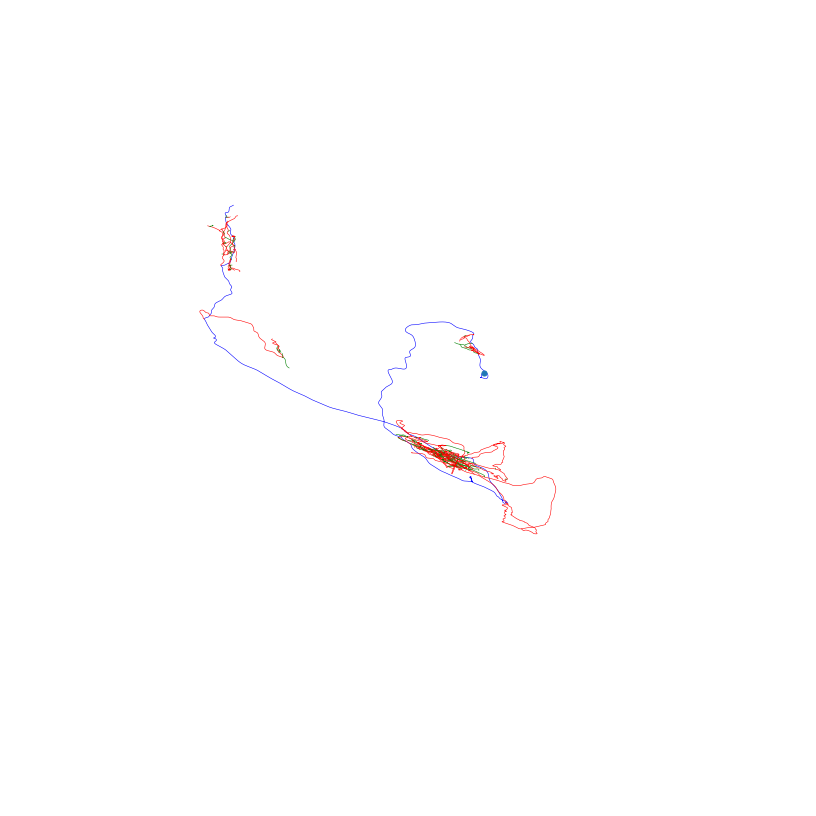

In [29]:
def node_height(G, node):
    predecessors = list(G.predecessors(node))
    L = len(predecessors)
    assert L == 1 or L == 0
    if L == 0:
        return 0
    else:
        return 1 + node_height(G, predecessors[0])

fig = plt.figure(figsize=(12, 10), dpi=80)
ax = Axes3D(fig)

for j, node in enumerate(spline_tree.nodes):
    spline = spline_tree.nodes[node]
    spline_height = node_height(spline_tree, node)
    tck, u_um = spline["spline"]
    y = splev(np.arange(u_um[0],u_um[-1], 0.1), tck)

    if spline_height == 0:
        c = "b"
        ax.scatter(y[0][0],y[1][0],y[2][0],'b')
    else:
        successors = spline_tree.successors(node)
        if len(list(successors)) == 0:
            c = "g"
        else:
            c = "r"

    ax.plot(y[0], y[1], y[2], c, linewidth=0.5)

ax.set_axis_off()

### View one of the branches

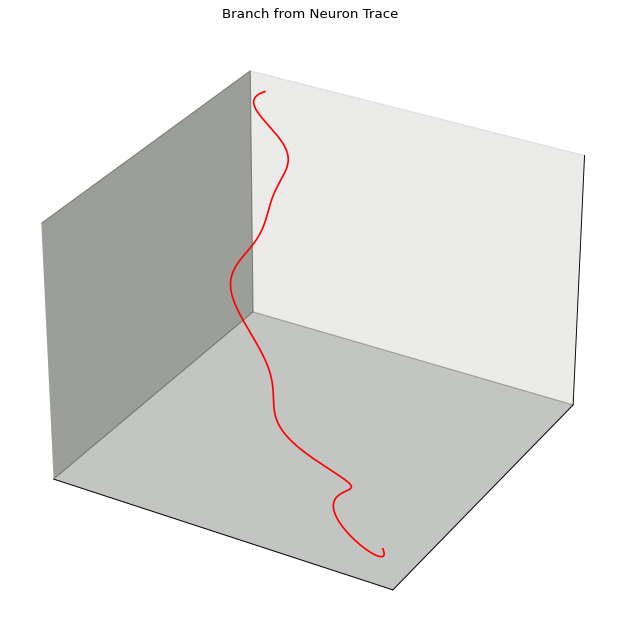

In [33]:
node = 7

path = spline_tree.nodes[node]["path"]
locs = np.zeros((len(path),3))
for p,point in enumerate(path):
    locs[p,:] = neuron.nodes[point]["loc"]

spline = spline_tree.nodes[node]["spline"]
u = spline[1]
u = np.arange(u[0], u[-1]+0.9, 1)
tck = spline[0]
pts = splev(u, tck)

fig = plt.figure(figsize=(12, 10), dpi=80)
ax = fig.add_subplot(111,projection="3d")
ax.plot(pts[0], pts[1], pts[2], 'red')
ax.w_xaxis.set_pane_color((0.23, 0.25, 0.209, 0.5))
ax.w_yaxis.set_pane_color((0.23, 0.25, 0.209, 0.1))
ax.w_zaxis.set_pane_color((0.23, 0.25, 0.209, 0.3))
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_title("Branch from Neuron Trace")
plt.axis('on')
plt.show()

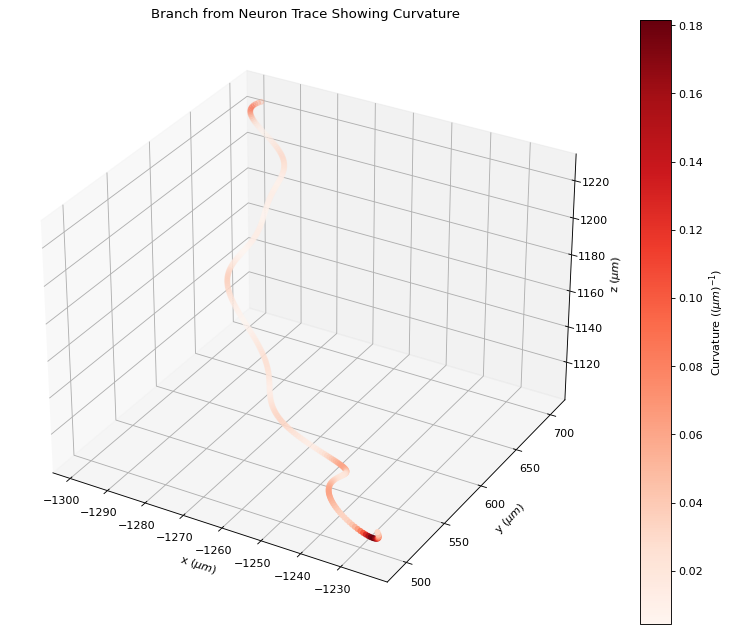

In [34]:
curvature = spline_fxns.curvature(u, tck[0], tck[1], tck[2])
ra_eq, cdf = hist_equalize(curvature, 100)

fig = plt.figure(figsize=(12, 10), dpi=80)
ax = fig.add_subplot(111,projection="3d")
im = ax.scatter(pts[0], pts[1], pts[2], c=curvature, cmap='Reds')
ax.set_xlabel('x ($\mu m$)')
ax.set_ylabel('y ($\mu m$)')
ax.set_zlabel('z ($\mu m$)')
ax.set_title("Branch from Neuron Trace Showing Curvature")
cbar = fig.colorbar(im)
cbar.set_label('Curvature ($(\mu m)^{-1}$)')

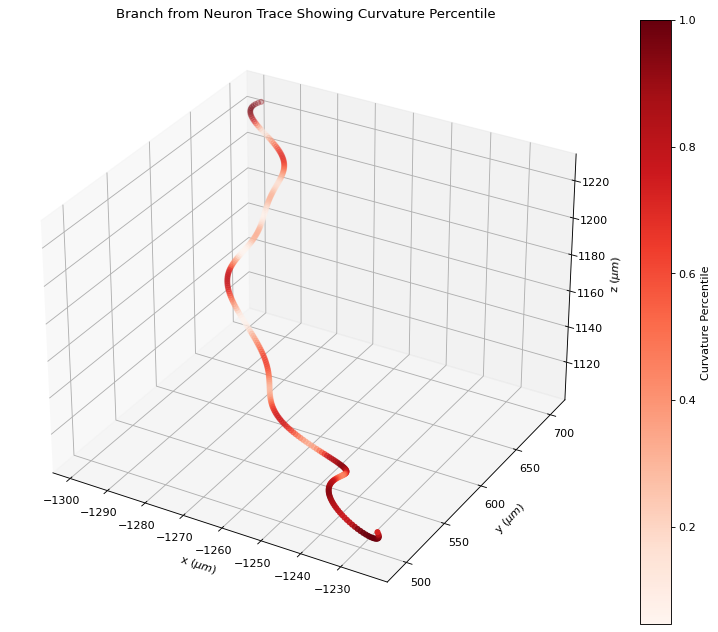

In [35]:
ra_eq, cdf = hist_equalize(curvature, 100)

fig = plt.figure(figsize=(12, 10), dpi=80)
ax = fig.add_subplot(111,projection="3d")
im = ax.scatter(pts[0], pts[1], pts[2], c=ra_eq, cmap='Reds')
ax.set_xlabel('x ($\mu m$)')
ax.set_ylabel('y ($\mu m$)')
ax.set_zlabel('z ($\mu m$)')
ax.set_title("Branch from Neuron Trace Showing Curvature Percentile")
cbar = fig.colorbar(im)
cbar.set_label('Curvature Percentile')

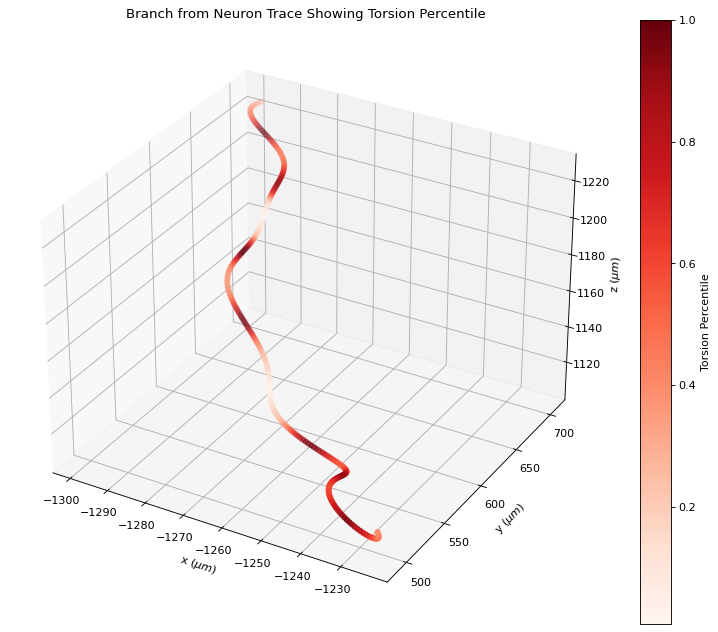

In [36]:
torsion = spline_fxns.torsion(u, tck[0], tck[1], tck[2])
ra_eq, cdf = hist_equalize(torsion, 100)

fig = plt.figure(figsize=(12, 10), dpi=80)
ax = fig.add_subplot(111,projection="3d")
im = ax.scatter(pts[0], pts[1], pts[2], c=ra_eq, cmap='Reds')
ax.set_xlabel('x ($\mu m$)')
ax.set_ylabel('y ($\mu m$)')
ax.set_zlabel('z ($\mu m$)')
ax.set_title("Branch from Neuron Trace Showing Torsion Percentile")
cbar = fig.colorbar(im)
cbar.set_label('Torsion Percentile')